# Forecast 4
nachdem mit einem Forecast gut läuft hier mal +4


In [1]:
# mal wieder alles rein laden:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time
from sklearn.model_selection import train_test_split
#%matplotlib inline

D:\ProgramData\Anaconda3\envs\ten-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Parameter
# Network Parameters
n_target = 5 # versuch forecast der nächsten X
n_seq = n_target * 4 # sequenz für split der Daten ist 4 fach
n_input = n_seq - n_target  # input shape für NN
# so versuch Layer in Abhängigkeit von input
n_hidden_1 = n_input**2#256# 1st layer number of features
n_hidden_2 = int(n_hidden_1 / 2) #128 # 2nd layer number of features
n_hidden_3 = int(n_hidden_2 / 2) #64 # 2nd layer number of features
n_hidden_4 = int(n_hidden_3 / 2) #32 # 2nd layer number of features
# Parameters
learning_rate = 0.001
#So ein Prezepton muss ne weile lernen :)
training_epochs = 250
batch_size = 120

In [3]:
def load_data():
    df = pd.read_csv("data/bitcoin_short.csv", index_col=1)
    # df_val= Open Value
    df_val = df.drop(columns='Close').drop(columns='High').drop(columns='Low')
    #df_targ= CLose Value
    df_targ = df.drop(columns='Open').drop(columns='High').drop(columns='Low')
    return df, df_val, df_targ

In [4]:
# Teile DAten auf in 6 Teile verlauf und 4 Teile Forecast.
# erstmal so ich werde mir das vll iterativ anschauen...
def split_forecast(df_val):
    data = df_val.values.reshape(-1,10)
    new_dat= []
    new_targ= [[]]
    for dat in data:
        new_dat = np.append(new_dat, dat[:-4])
        new_targ = np.append(new_targ, dat[-4:])
    new_dat = new_dat.reshape(-1,6)
    new_targ = new_targ.reshape(-1,4)
    print("new_dat: ", new_dat.shape)
    print("new_targ: ", new_targ.shape)
    return new_dat, new_targ


In [5]:
# So hier wird der Datensatz sequentiell aufgeteilt
def split_seq(df_val, seq, pre_seq):
    data = df_val.values
    check_size = seq - pre_seq
    print(check_size)
    new_dat= []
    new_targ= []
    print("länge: ", len(data)-seq)
    for i in range(len(data)-seq):
        new_dat = np.append(new_dat, data[i:i+check_size])
        new_targ = np.append(new_targ, data[i+check_size:i+seq])
        #output eingebaut, dat dauert lange... mal schauen ob ich das mit list slice nicht auch hin bekomme...
        if i%6000 == 0:
            print("bin noch da: ", i, " ", new_dat.shape)
    new_dat = new_dat.reshape(-1,check_size)
    new_targ = new_targ.reshape(-1,pre_seq)
    print(new_dat.shape)
    print(new_targ.shape)
    return new_dat, new_targ
        
        

In [6]:
df, df_val, df_targ = load_data()
# split ds, seq-länge, forecast
x_seq, y_seq = split_seq(df_val, n_seq, n_target)

15
länge:  51233
bin noch da:  0   (15,)
bin noch da:  6000   (90015,)
bin noch da:  12000   (180015,)
bin noch da:  18000   (270015,)
bin noch da:  24000   (360015,)
bin noch da:  30000   (450015,)
bin noch da:  36000   (540015,)
bin noch da:  42000   (630015,)
bin noch da:  48000   (720015,)
(51233, 15)
(51233, 5)


In [7]:
#nur kurz zum Prüfen der Daten...
print(x_seq[0])
print(y_seq[0])
print(df_val[:n_seq])

[9372.00000001 9379.99999997 9412.99999318 9420.03499994 9374.
 9367.43814562 9366.00059    9390.33978874 9371.00005511 9350.00000006
 9289.0000037  9276.00010111 9312.53405687 9289.09999852 9214.54892906]
[9202.00000004 9285.46       9255.00000007 9166.07635825 9105.        ]
                   Open
Timestamp              
1517496900  9372.000000
1517497500  9380.000000
1517497800  9412.999993
1517498100  9420.035000
1517498400  9374.000000
1517498700  9367.438146
1517499000  9366.000590
1517499300  9390.339789
1517499600  9371.000055
1517499900  9350.000000
1517500200  9289.000004
1517500500  9276.000101
1517500800  9312.534057
1517501100  9289.099999
1517501400  9214.548929
1517501700  9202.000000
1517502000  9285.460000
1517502300  9255.000000
1517502600  9166.076358
1517502900  9105.000000


In [8]:
#Achtung wir brauchen Mod10 Daten => wir lassen Mod10 rest weg :)
x_data, y_data = split_forecast(df_val[:-(len(df_val)%10)])
#skalieren der Daten
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data2 = min_max_scaler.fit_transform(x_seq)
target2 = min_max_scaler.fit_transform(y_seq)
#aufteieln in test und train
x_train, x_test, y_train, y_test = train_test_split(data2, target2, random_state=23111, test_size=0.35)
#datax und datay komplett
datax = data2
datay = target2

new_dat:  (5125, 6)
new_targ:  (5125, 4)


# TF implementierung eigenes Prezepton
einfach mal zum Spaß 4 Layer Prezepton

In [9]:
#Batch erstellen, gut hab ich ganz verstanden aber läuft. ;)
index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)


# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)  # shuffle permutation array
        start = 0  # start next epoch
        index_in_epoch = batch_size

    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [10]:
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_target])

## das Prezepton
Hatte etwas rum gespielt und mit relu6 und softmax gute Ergebinsse erzielt

In [11]:
def multilayer_perceptron(x, weights, biases):
    '''
    x : Place Holder for Data Input
    weights: Dictionary of weights
    biases: Dicitionary of biases
    '''
    
    # First Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu6(layer_1)
    
    # Second Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu6(layer_2)
    
    # Second Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu6(layer_3)
    
    # Second Hidden layer with RELU activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.softmax(layer_4)
    
    # Last Output layer with linear activation
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer

## und jetzt die Maße und Gewichte :)

In [12]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'out': tf.Variable(tf.random_normal([n_hidden_4, n_target]))
}

In [13]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'out': tf.Variable(tf.random_normal([n_target]))
}

In [14]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)
# Define loss and optimizer
cost = tf.reduce_mean(tf.square(pred - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [15]:
# Initializing the variables
init = tf.global_variables_initializer()
print(int(x_train.shape[0]/batch_size))

277


## so jetzt wird aber mal trainiert 

In [16]:
# Launch the session
sess = tf.InteractiveSession()

# Intialize all the variables
sess.run(init)

# Training Epochs
# Essentially the max amount of loops possible before we stop
# May stop earlier if cost/loss limit was set
for epoch in range(training_epochs):

    # Start with cost = 0.0
    avg_cost = 0.0

    # Convert total number of batches to integer
    total_batch = int(x_train.shape[0]/batch_size)#32#int(x_train.shape[0]/batch_size)

    # Loop over all batches
    for i in range(total_batch):

        # Grab the next batch of training data and labels
        batch_x, batch_y = get_next_batch(batch_size)

        # Feed dictionary for optimization and loss value
        # Returns a tuple, but we only need 'c' the cost
        # So we set an underscore as a "throwaway"
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})

        # Compute average loss
        avg_cost += c / total_batch

    if epoch%10 == 0:
        print("Epoch: {} cost={:.4f}".format(epoch+1,avg_cost))
        

print("Model has completed {} Epochs of Training".format(training_epochs))


Epoch: 1 cost=0.7648
Epoch: 11 cost=0.1983
Epoch: 21 cost=0.1982
Epoch: 31 cost=0.1982
Epoch: 41 cost=0.1983
Epoch: 51 cost=0.1982
Epoch: 61 cost=0.1982
Epoch: 71 cost=0.1981
Epoch: 81 cost=0.1982
Epoch: 91 cost=0.0036
Epoch: 101 cost=0.0008
Epoch: 111 cost=0.0005
Epoch: 121 cost=0.0005
Epoch: 131 cost=0.0004
Epoch: 141 cost=0.0003
Epoch: 151 cost=0.0003
Epoch: 161 cost=0.0004
Epoch: 171 cost=0.0003
Epoch: 181 cost=0.0003
Epoch: 191 cost=0.0003
Epoch: 201 cost=0.0003
Epoch: 211 cost=0.0003
Epoch: 221 cost=0.0003
Epoch: 231 cost=0.0003
Epoch: 241 cost=0.0003
Model has completed 250 Epochs of Training


## so jetzt schauen wir mal was das Model zu den Testdaten sagt...

In [17]:
mse_valid = cost.eval(feed_dict={x: x_test, y: y_test})
print("MSE Test Data: ",mse_valid)

MSE Test Data:  0.0002580745


## und jetzt lassen wir es mal auf ne Sequenz der Daten los
mal schauen was es wir :)

In [18]:
x_valid = datax[-128:]
y_valid = datay[-128:]
y_test_pred = sess.run(pred, feed_dict={x: x_valid})

## Bildchen
nochmal: wir lassen 5 zahlen forecasten ist eigentlich wurst welche wir uns anzeigen lassen.
Ich nehm den letzen, wichtig ist nur das wir beim Valid DS den gleichen nehmen..

<function matplotlib.pyplot.show(*args, **kw)>

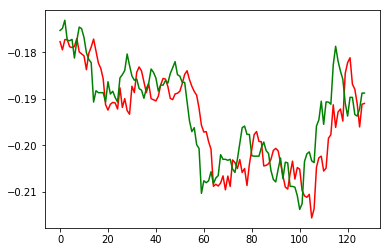

In [19]:
#y_test_pred = y_test_pred.reshape(-1,1)
plt.plot(y_test_pred[:,n_target-1], color='red', label='Prediction')
plt.plot(y_valid[:,n_target-1], color='green', label='Is so Daten')
plt.show

nicht ganz getroffen :(
Verlauf schaut aber gar nicht so schlecht aus

## Aufs ganze
So jetzt lass ich den auf das ganze DS los

In [20]:
y_all_pred = sess.run(pred, feed_dict={x: datax})
mse_all = cost.eval(feed_dict={x: datax, y: datay})
print("MSE auf das Ganze: ",mse_all)

MSE auf das Ganze:  0.00025263565


<function matplotlib.pyplot.show(*args, **kw)>

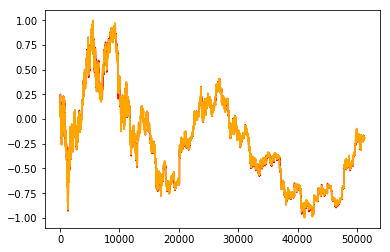

In [21]:
plt.plot(y_all_pred[:,n_target-1], color='red', label='Prediction')
plt.plot(datay[:,n_target-1], color='orange', label='Is so Daten')
plt.show

In [22]:
y_fu_pred = sess.run(pred, feed_dict={x: datax[-1:]})

In [23]:
y_fu_pred.reshape(-1,1)

array([[-0.19070971],
       [-0.19120678],
       [-0.19135553],
       [-0.19115081],
       [-0.1910036 ]], dtype=float32)

[[-0.1945263  -0.19052125 -0.19550166 -0.19066463 -0.19071242 -0.19116701
  -0.18269796 -0.17869798 -0.18186623 -0.18403129 -0.1858013  -0.19093058
  -0.1937229  -0.1896847  -0.18969792]]


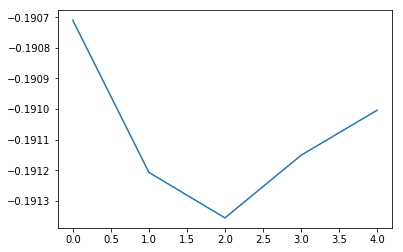

In [24]:
print(datax[-1:])
plt.plot(y_fu_pred.reshape(-1,1))